In [1]:
import torch

def kron(A, B):  # alias
    return torch.kron(A, B)

def E_site(core):  # core: [chi,2,chi] -> (E, (E0,E1)) in double layer
    B0, B1 = core[:,:,0], core[:,:,1]
    E0 = kron(B0, B0.conj())
    E1 = kron(B1, B1.conj())
    return (E0 + E1), (E0, E1)
import numpy as np

@torch.no_grad()
def precompute_double_layer_and_right_suffix(cores):
    """
    Returns:
      Es: [(E0,E1)] length n, each [chi^2,chi^2]
      R_suf: [n] where R_suf[i] = E_{i+1} ... E_{n-1} (identity if i==n-1)
      d2, device, dtype
    """
    device = cores[0].device
    dtype  = torch.complex128 if torch.is_complex(cores[0]) else torch.float64

    E_list, Es = [], []
    for c in cores:
        c = c.to(dtype)
        Ei, (Ei0, Ei1) = E_site(c)
        E_list.append(Ei)
        Es.append((Ei0, Ei1))

    n  = len(E_list)
    d2 = E_list[0].shape[0]
    I  = torch.eye(d2, dtype=E_list[0].dtype, device=device)

    # Build right suffixes with a left->right pass on the reversed list,
    # but crucially LEFT-multiply to preserve forward order:
    # Rpref_rev[j] = E_{n-1} ... E_{n-j}
    Rpref_rev = [None] * (n + 1)
    acc = I
    Rpref_rev[0] = acc
    E_rev = E_list[::-1]  # [E_{n-1}, E_{n-2}, ..., E_0]
    for j in range(1, n + 1):
        acc = E_rev[j - 1] @ acc        # <-- left-multiply (critical)
        Rpref_rev[j] = acc

    # Map back: for site i, R_suf[i] = E_{i+1} ... E_{n-1} = Rpref_rev[n-(i+1)]
    R_suf = [Rpref_rev[n - (i + 1)] for i in range(n)]
    return Es, R_suf, d2, device, dtype

def _batch_trace(M):  # M: [B,d2,d2] -> [B]
    return M.diagonal(dim1=-2, dim2=-1).sum(-1).real

@torch.no_grad()
def sample_tr_born_batch_noinv_LE(cores, batch_size=1000, seed=None, chunk_size=128):
    """
    Exact Born-rule sampling on a periodic MPS/tensor ring.
    - little-endian (site 0 = LSB)
    - no solves/inverses
    - batched (processed in chunks)
    """
    Es, R_suf, d2, device, dtype = precompute_double_layer_and_right_suffix(cores)
    n = len(Es)
    #R_suf = precompute_double_layer_and_right_suffix(cores)
    out = torch.empty((batch_size, n), dtype=torch.long, device='cuda')
    gen = torch.Generator(device=device)
    if seed is not None:
        gen.manual_seed(seed)

    for start in range(0, batch_size, chunk_size):
        end = min(start + chunk_size, batch_size)
        B = end - start

        # Left env for all samples in chunk
        L = torch.eye(d2, dtype=dtype, device=device).expand(B, d2, d2).clone()

        for i in range(n):
            # Precompute L @ E_i(0/1)
            Ei0, Ei1 = Es[i]
            T0 = L @ Ei0                 # [B,d2,d2]
            T1 = L @ Ei1                # [B,d2,d2]
            # Weights: w_s = Tr( (L E_i(s)) * R_i )

            Ri = R_suf[i]     # [1,d2,d2]
            w0 = _batch_trace(T0 @ Ri)         # [B]
            w1 = _batch_trace(T1 @ Ri)         # [B]
            # print(Ri.shape)
            # print(T0.shape)

            # tr0= T0 @ Ri.to(dtype)
            # tr1= T1 @ Ri.to(dtype)
            # print("tr0 shape")
            # print(tr0.shape)
            
            # w0 = torch.einsum('bij,bij->b', tr0.conj(), tr0).real  # (shots,)
            # w1 = torch.einsum('bij,bij->b', tr1.conj(), tr1).real
            # # w0 = torch.einsum('bij,bij->b', tr0.conj(), tr0).real  # (shots,)
            # # w1 = torch.einsum('bij,bij->b', tr1.conj(), tr1).real
            denom = (w0 + w1).clamp_min(1e-300)
            p0 = (w0.clamp_min(0.0) / denom).to(torch.float64)

            r  = torch.rand((B,), generator=gen, device=device)
            si = (r >= p0).long()              # 0 with prob p0, else 1
            out[start:end, i] = si.cpu()

            # Update L <- L E_i(si): select T0/T1
            L = torch.where(si.view(B,1,1)==0, T0, T1)

            # stabilize occasionally
            if (i % 8) == 0 and i != 0:
                nL = torch.linalg.norm(L.reshape(B, -1), dim=1).clamp_min(1e-300).view(B,1,1)
                L = L / nL

    return out


# ---------- exact distribution from cores (for validation) ----------
@torch.no_grad()
def probs_exact_from_cores_double_layer(cores):
    """
    Exact little-endian probabilities from TR cores via double-layer contraction:
    p[idx] ∝ Tr( ∏_i E_i(s_i) ), where idx encodes s_i in little-endian.
    """
    device = cores[0].device
    dtype  = torch.complex128 if torch.is_complex(cores[0]) else torch.float64
    Es = []
    for c in cores:
        c = c.to(dtype)
        B0, B1 = c[:,:,0], c[:,:,1]
        E0 = kron(B0, B0.conj())
        E1 = kron(B1, B1.conj())
        Es.append((E0, E1))
    n   = len(cores)
    d2  = Es[0][0].shape[0]
    I   = torch.eye(d2, dtype=Es[0][0].dtype, device=device)

    probs = torch.zeros(1<<n, dtype=torch.float64, device=device)
    for idx in range(1<<n):
        M = I
        for i in range(n):  # little-endian bits
            s = (idx >> i) & 1
            M = M @ Es[i][s]
        probs[idx] = torch.trace(M).real
    s = probs.sum()
    if s > 0:
        probs /= s
    return probs




import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from pyparsing import Optional
import torch
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp

# TRVQA imports
from TRVQA.circuit import Circuit
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
from TRVQA.measure.enums import MeasureMethod
torch.cuda.empty_cache()
import numpy as np
import torch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp

# --- Parameters ---
num_qubit = 4
num_layers = 1  # depth

# Random thetas
theta = torch.tensor(
    np.random.uniform(0, 2*np.pi, num_qubit * 2 * num_layers),
    dtype=torch.float32
)

# --- Build Qiskit Hamiltonian: Z on each qubit with random coefficients ---
pauli_terms = []
coeffs = np.random.uniform(-5, 5, num_qubit)
for i in range(1):   # adjust if you want more terms
    pauli_str = ['I'] * num_qubit
    pauli_str[i] = 'Z'
    pauli_terms.append((''.join(pauli_str[::-1]), 1.0))  # fixed coeff=1 for clarity

hamiltonian_qiskit = SparsePauliOp.from_list(pauli_terms)

# --- Qiskit ansatz circuit: RX, RY, CX ---
qc = QuantumCircuit(num_qubit)
theta_idx = 0
for _ in range(num_layers):
    for i in range(num_qubit):
        qc.rx(theta[theta_idx].item(), i); theta_idx += 1
        qc.ry(theta[theta_idx].item(), i); theta_idx += 1
    for i in range(num_qubit - 1):
        qc.cx(i, i + 1)
    qc.cx(num_qubit - 1, 0)

# Statevector expectation
state = Statevector.from_instruction(qc)
sv_dist_ring = state.probabilities_dict()
expval_sv = np.real(state.expectation_value(Operator(hamiltonian_qiskit.to_matrix())))
print(f"Statevector expectation value ({num_qubit} qubits): {expval_sv}")

# --- TRVQA circuit ---
circuit_trvqa = Circuit(num_qubit, rank=10, device='cuda')
theta_idx = 0
for _ in range(num_layers):
    for i in range(num_qubit):
        circuit_trvqa.rx(i); theta_idx += 1
        circuit_trvqa.ry(i); theta_idx += 1
    for i in range(num_qubit - 1):
        circuit_trvqa.cx(i, i + 1)
    circuit_trvqa.cx(num_qubit - 1, 0)

hamiltonian_trvqa = Hamiltonian(num_qubit)
for pauli, coeff in pauli_terms:
    hamiltonian_trvqa.add_pauli(pauli[::-1], coeff)


samples = sample_tr_born_batch_noinv_LE(circuit_trvqa.build_tensor(theta), batch_size=10000, seed=123, chunk_size=1000)

ps_dist_ring = circuit_trvqa.measure(theta, method=MeasureMethod.SAMPLING, shots=10000)


rs_dist_ring = [0]*(2**num_qubit)
for s in samples:
    idx = sum([s_i * (2**i) for i, s_i in enumerate(s)])
    rs_dist_ring[idx] += 1/samples.size(0)


Statevector expectation value (4 qubits): 0.04966984032360802


In [2]:

# Random thetas
theta = torch.tensor(
    np.random.uniform(0, 2*np.pi, num_qubit * 2 * num_layers),
    dtype=torch.float32
)

# --- Build Qiskit Hamiltonian: Z on each qubit with random coefficients ---
pauli_terms = []
coeffs = np.random.uniform(-5, 5, num_qubit)
for i in range(1):   # adjust if you want more terms
    pauli_str = ['I'] * num_qubit
    pauli_str[i] = 'Z'
    pauli_terms.append((''.join(pauli_str[::-1]), 1.0))  # fixed coeff=1 for clarity

hamiltonian_qiskit = SparsePauliOp.from_list(pauli_terms)

# --- Qiskit ansatz circuit: RX, RY, CX ---
qc = QuantumCircuit(num_qubit)
theta_idx = 0
for _ in range(num_layers):
    for i in range(num_qubit):
        qc.rx(theta[theta_idx].item(), i); theta_idx += 1
        qc.ry(theta[theta_idx].item(), i); theta_idx += 1
    for i in range(num_qubit - 1):
        qc.cx(i, i + 1)

# Statevector expectation
state = Statevector.from_instruction(qc)
sv_dist_no_ring = state.probabilities_dict()
expval_sv = np.real(state.expectation_value(Operator(hamiltonian_qiskit.to_matrix())))
print(f"Statevector expectation value ({num_qubit} qubits): {expval_sv}")

# --- TRVQA circuit ---
circuit_trvqa = Circuit(num_qubit, rank=10, device='cuda')
theta_idx = 0
for _ in range(num_layers):
    for i in range(num_qubit):
        circuit_trvqa.rx(i); theta_idx += 1
        circuit_trvqa.ry(i); theta_idx += 1
    for i in range(num_qubit - 1):
        circuit_trvqa.cx(i, i + 1)

hamiltonian_trvqa = Hamiltonian(num_qubit)
for pauli, coeff in pauli_terms:
    hamiltonian_trvqa.add_pauli(pauli[::-1], coeff)


samples = sample_tr_born_batch_noinv_LE(circuit_trvqa.build_tensor(theta), batch_size=10000, seed=123, chunk_size=1000)

ps_dist_no_ring = circuit_trvqa.measure(theta, method=MeasureMethod.SAMPLING, shots=10000)


rs_dist_no_ring = [0]*(2**num_qubit)
for s in samples:
    idx = sum([s_i * (2**i) for i, s_i in enumerate(s)])
    rs_dist_no_ring[idx] += 1/samples.size(0)

# #prob_list = probs_exact_from_cores_double_layer(circuit_trvqa.build_tensor(theta)).cpu().numpy()
# #prob_list = circuit_trvqa.measure(theta, method=MeasureMethod.CONTRACTION)
# bitstrings = [format(i, f'0{num_qubit}b') for i in range(2**num_qubit)]
# print('Bitstring | Qiskit Prob | TRVQA Prob | Diff')
# for idx, b in enumerate(bitstrings):
#     qiskit_prob = sv_dist_ring.get(b, 0.0)
#     trvqa_prob = rs_dist_ring[idx] if idx < len(rs_dist_ring) else 0.0
#     diff = qiskit_prob - trvqa_prob
    
#     if qiskit_prob != 0:
#         perc_diff = (diff / qiskit_prob) * 100
#     else:
#         perc_diff = 0.0  # avoid division by zero
    
#     print(f'{b} | {qiskit_prob:.6f} | {trvqa_prob:.6f} | {diff:+.6f} | {perc_diff:+.2f}%')




Statevector expectation value (4 qubits): 0.7806980121749755


In [3]:
sv_dist_ring
bitstrings = [format(i, f'0{num_qubit}b') for i in range(2**num_qubit)]
sv_dist_ring_list = []
for b in bitstrings:
    sv_dist_ring_list.append(sv_dist_ring.get(b, 0.0))

sv_dist_no_ring_list = []
for b in bitstrings:
    sv_dist_no_ring_list.append(sv_dist_no_ring.get(b, 0.0))

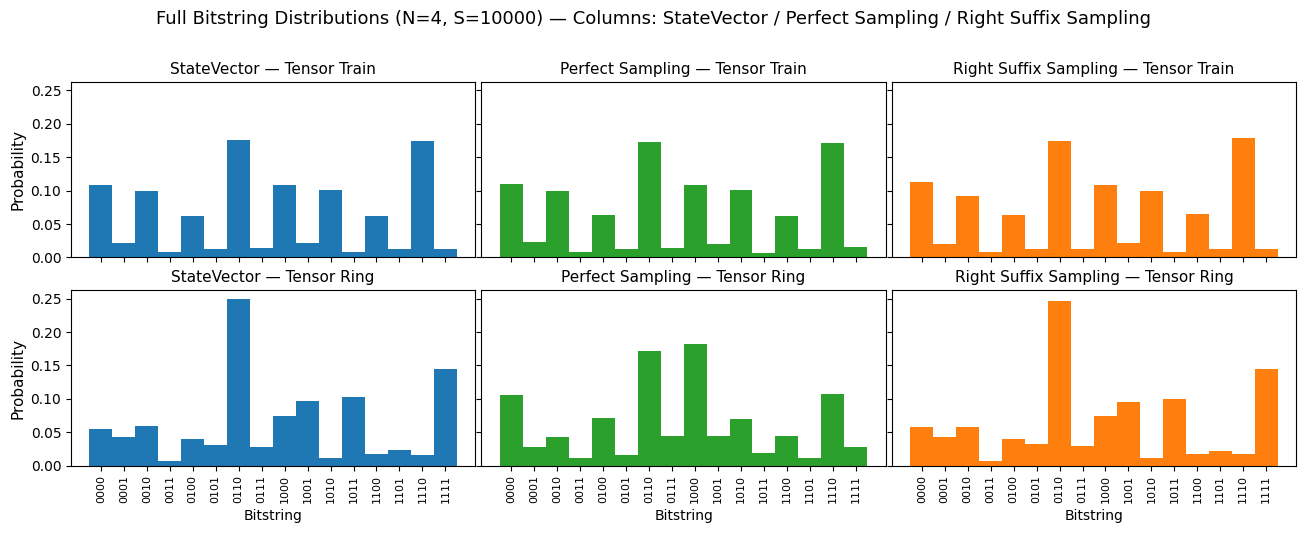

Saved figure: data/N4_2x3_grid_samecolor_tight.png


In [9]:
# 2x3 grid: rows = {Non-ring, Ring}, columns = {Exact, TR, TR-correct}
# Uniform colors per method, tight layout, no gaps, outputs to ./data/

import os, numpy as np, matplotlib.pyplot as plt

OUT = "data"
os.makedirs(OUT, exist_ok=True)

N, S = num_qubit, 10000

def bitlabels(N):
    return [format(k, f"0{N}b") for k in range(1<<N)]

# ---------- Synthetic Demo (replace with your real data) ----------
rng = np.random.default_rng(0)


# # Non-ring
# p_nonring = np.array([0.25, 0.35, 0.5, 0.6])
# samples_exact_nonring = sample_with_flip(p_nonring, 0.00)
# samples_tr_nonring    = sample_with_flip(p_nonring, 0.04)
# samples_trcorr_nonring= sample_with_flip(p_nonring, 0.015)
# print(samples_trcorr_nonring)
# # Ring
# p_ring = np.array([0.5, 0.45, 0.4, 0.35])
# samples_exact_ring    = sample_with_flip(p_ring, 0.00)
# samples_tr_ring       = sample_with_flip(p_ring, 0.08)
# samples_trcorr_ring   = sample_with_flip(p_ring, 0.02)

# ---------- Build distributions ----------
exact_nonring = exact_ring    = sv_dist_no_ring_list
tr_nonring    = ps_dist_no_ring
trc_nonring   = rs_dist_no_ring
exact_ring    = sv_dist_ring_list
tr_ring       = ps_dist_ring
trc_ring      = rs_dist_ring

labels = bitlabels(N)
x = np.arange(1<<N)

# ---------- Plot 2x3 grid ----------
fig, axes = plt.subplots(2, 3, figsize=(13, 5), sharex=True, sharey=True)

# consistent colors
colors = {
    "StateVector": "#1f77b4",      # blue
    "Perfect Sampling": "#2ca02c",  # green
    "Right Suffix Sampling": "#ff7f0e"         # orange
}

titles = ["StateVector", "Perfect Sampling", "Right Suffix Sampling"]

# Top row: Non-ring
for j, (p, title) in enumerate(zip([exact_nonring, tr_nonring, trc_nonring], titles)):
    axes[0, j].bar(x, p, color=colors[title], width=1.0)
    axes[0, j].set_title(f"{title} — Tensor Train", fontsize=11)
    axes[0, j].set_xticks([])
    if j == 0:
        axes[0, j].set_ylabel("Probability", fontsize=11)

# Bottom row: Ring
for j, (p, title) in enumerate(zip([exact_ring, tr_ring, trc_ring], titles)):
    axes[1, j].bar(x, p, color=colors[title], width=1.0)
    axes[1, j].set_title(f"{title} — Tensor Ring", fontsize=11)
    axes[1, j].set_xticks(x)
    axes[1, j].set_xticklabels(labels, rotation=90, fontsize=8)
    if j == 0:
        axes[1, j].set_ylabel("Probability", fontsize=11)
    axes[1, j].set_xlabel("Bitstring", fontsize=10)

fig.suptitle(f"Full Bitstring Distributions (N={N}, S={S}) — Columns: StateVector / Perfect Sampling / Right Suffix Sampling", y=1.04, fontsize=13)
fig.tight_layout(pad=0.5, w_pad=0.1, h_pad=0.3)

path = os.path.join(OUT, "N4_2x3_grid_samecolor_tight.png")
plt.savefig(path, dpi=600, bbox_inches="tight")
plt.show()
plt.close()

print("Saved figure:", path)
